# ATMOS 2022 - MODIS Analysis

-----------

## 0. Import Libraries

In [2]:
from utils.data import *
from utils.utils import *
from utils.visualization_codes import *
import matplotlib.pyplot as plt
import seaborn as sns
import proplot

%load_ext autoreload
%autoreload 2
%reload_ext autoreload

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## 1. Creating Urban-Rural Temperature Dataset

In [2]:
provinces = ['istanbul', 'ankara']
class_types = ['urban', 'rural']
source_type = 'terra'

# numbers starting with 2 or 3: urban
# numbers starting with 1 except 10: rural
# number 10: water
urban_tiles = [21,22,23,30]
rural_tiles = [11,12,13]
lu_year = 2000

In [3]:
modis_data_dict = {}
# add urban and rural variables to the given province modis data
for province in provinces:
    
    # open modis and land use data
    province_lu_data = retrieve_ghs(province=province)
    province_modis_data = retrieve_modis_merged(province=province, source_type=source_type)
    
    # reproject modis data to match the grid of lu data
    lu_repr, modis_repr = regrid_match(province_lu_data, province_modis_data,  
                                       province_lu_data.rio.crs, province_modis_data.rio.crs,
                                       'x', 'y',
                                       'x', 'y')   
    
    # classify land use data to urban and rural tiles
    lu_repr_class = classify_urban_rural(lu_repr.sel(time=lu_year), urban_tiles, rural_tiles) 
    
    # K to C
    modis_repr = modis_repr - 273.15 
    
    # remove automatically created very big values (due to reprojection) and make a dataset
    modis_repr_copy = xr.where(modis_repr>500, np.nan, modis_repr).to_dataset(name='temp')
    
    # assign new variables named 'urban' and 'rural' containing the 'urban' and 'rural' tiles, respectively
    modis_repr_copy_class = modis_repr_copy.assign(urban=lambda x: xr.where(lu_repr_class==1, x.temp, np.nan)).transpose('time', 'y', 'x')
    modis_repr_copy_class = modis_repr_copy_class.assign(rural=lambda x: xr.where(lu_repr_class==0, x.temp, np.nan)).transpose('time', 'y', 'x')
    
    modis_data_dict[province] = modis_repr_copy_class

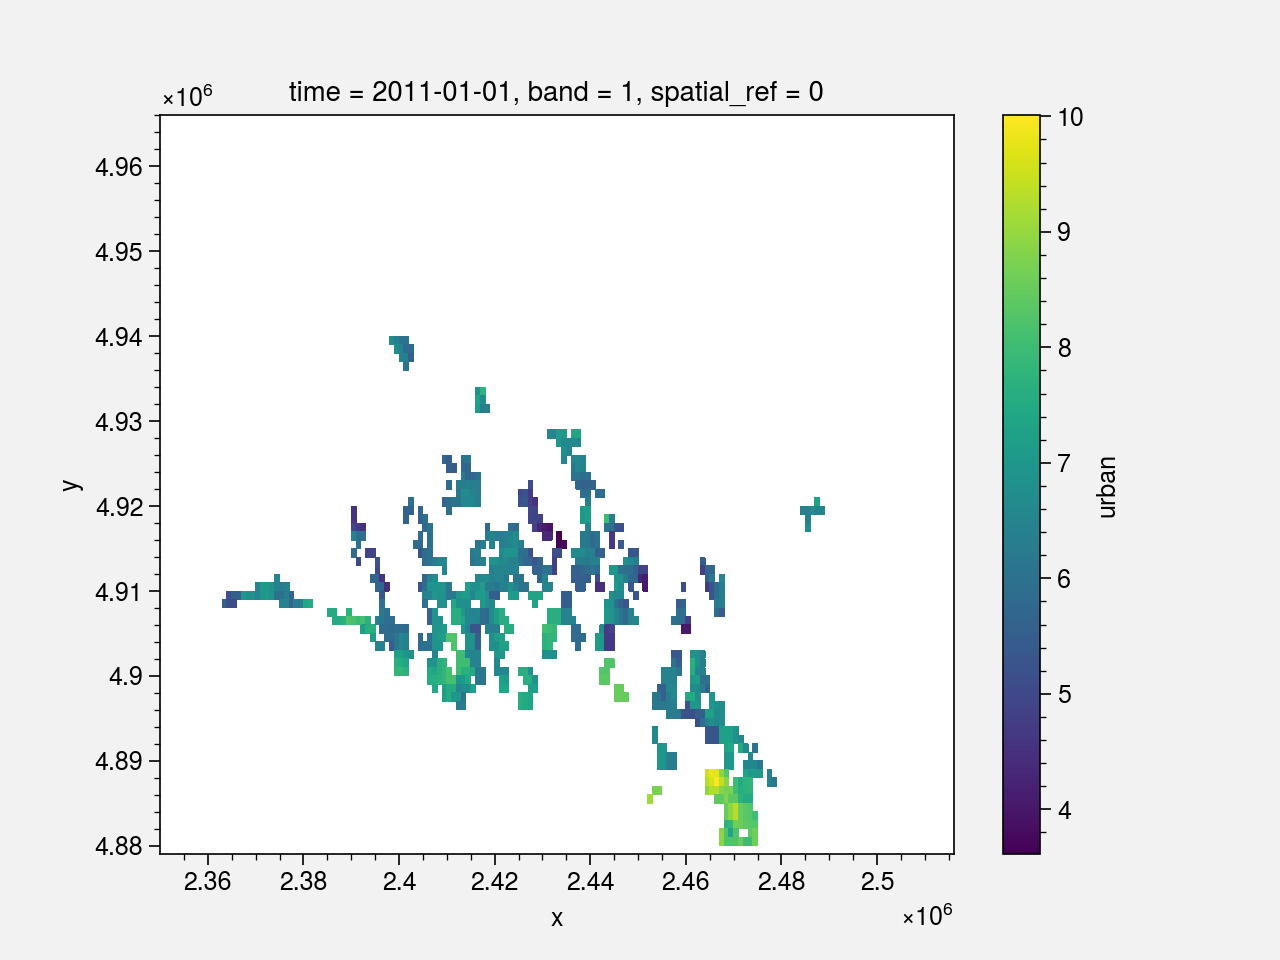

In [5]:
modis_data_dict['istanbul'].urban[0].plot()

## 2. Creating Urban-Rural Histograms

/home/berkaydonmez/anaconda3/envs/cirrus_env_v3/lib/python3.9/site-packages/proplot/ui.py:406: ProPlotWarning: You specified both figsize=(6, 3) and axwidth=1.5. Ignoring 'axwidth'.
/home/berkaydonmez/anaconda3/envs/cirrus_env_v3/lib/python3.9/site-packages/proplot/figure.py:94: MatplotlibDeprecationWarning: 
The 'optimize' parameter of print_jpg() was deprecated in Matplotlib 3.3 and will be removed two minor releases later. Use pil_kwargs={'optimize': ...} instead. If any parameter follows 'optimize', they should be passed as keyword, not positionally.
  result = func(self, *args, **kwargs)
/home/berkaydonmez/anaconda3/envs/cirrus_env_v3/lib/python3.9/site-packages/proplot/figure.py:94: MatplotlibDeprecationWarning: 
The 'progressive' parameter of print_jpg() was deprecated in Matplotlib 3.3 and will be removed two minor releases later. Use pil_kwargs={'progressive': ...} instead. If any parameter follows 'progressive', they should be passed as keyword, not positionally.
  result = f

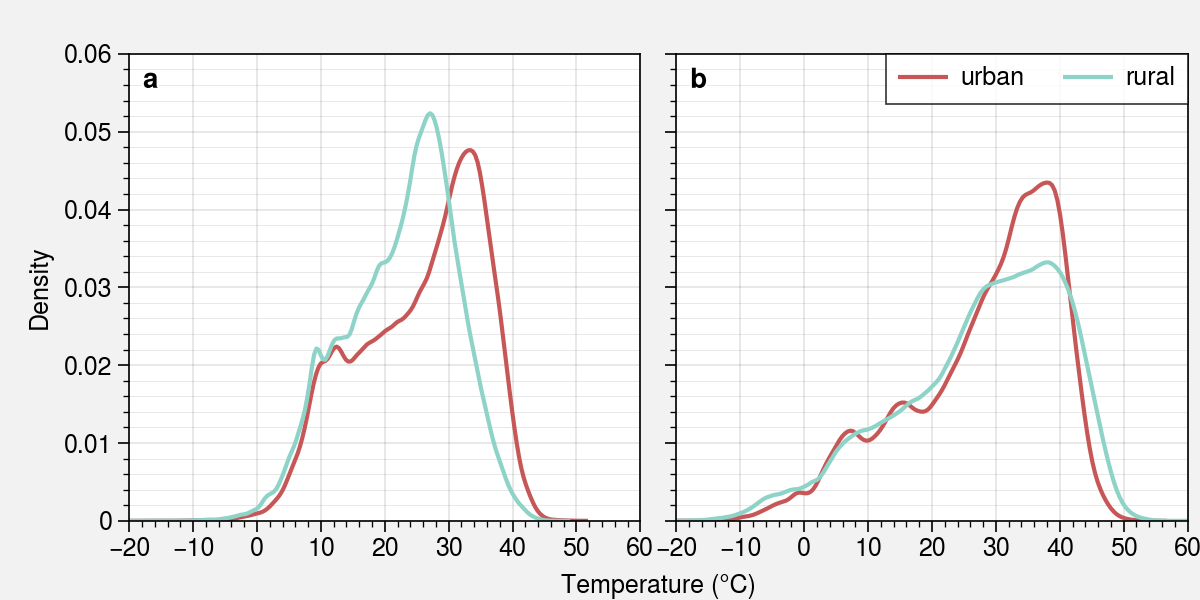

In [4]:
# start figure
f, axs = proplot.subplots(array=[[1, 2]], hratios=(1),
                          hspace=0.20, figsize=(6,3),
                          share=3, axwidth=1.5, tight=False)

# colors for lines
color_map = {'urban': '#c75757',
             'rural': '#8dd3c7'}

# make kdeplots containing urban and rural temperature distributions
for i, province in enumerate(provinces):
    
    # flatten and make a list out of the xarray datasets before plotting
    flatten_data_urban = remove_nan_from_array(np.array(modis_data_dict[province]['urban']).flatten())
    flatten_data_rural = remove_nan_from_array(np.array(modis_data_dict[province]['rural']).flatten())
    
    sns.kdeplot(flatten_data_urban, ax=axs[i], color=color_map['urban'], label='urban', legend=True)
    sns.kdeplot(flatten_data_rural, ax=axs[i], color=color_map['rural'], label='rural', legend=True)

# format subfigures
for i in range(2):
    axs[i].format(ylabel='Density', xlabel='Temperature (°C)',
                  ygridminor=True, ygrid=True, #title=provinces[i],
                  titleloc='ll', xrotation=0, xlim=(-20, 60), ylim=(0, 0.06),
                  xlocator=proplot.arange(-20, 60, 10))

# format whole figure
axs.format(abcloc='ul', abc=True,)
axs[1].legend()
    
# savefig    
plt.savefig(fr'pictures/modis_pdf_fig.jpeg',
            bbox_inches='tight', optimize=False,
            progressive=True, dpi=1000)

## 3. Creating Yearly, Monthly, and Seasonal Mean Line Plots

Get yearly, monthly, and seasonal value lists and make a separate dataframe for each of these lists

In [145]:
modis_data_dict['istanbul']

<xarray.Dataset>
Dimensions:      (x: 166, y: 87, time: 2899)
Coordinates:
  * x            (x) float64 2.35e+06 2.352e+06 ... 2.514e+06 2.516e+06
  * y            (y) float64 4.966e+06 4.964e+06 4.964e+06 ... 4.88e+06 4.88e+06
  * time         (time) datetime64[ns] 2011-01-01 2011-01-02 ... 2018-12-31
    band         int64 1
    spatial_ref  int64 0
Data variables:
    temp         (time, y, x) float32 nan nan nan nan 6.27 ... nan nan nan nan
    urban        (y, x, time) float32 dask.array<chunksize=(87, 166, 2899), meta=np.ndarray>
    rural        (y, x, time) float32 dask.array<chunksize=(87, 166, 2899), meta=np.ndarray>

In [5]:
yearly_mean_dict = {}
monthly_mean_dict = {}
seasonal_mean_dict = {}


for province in provinces:
    for class_type in class_types:
        
        # get a list of mean yearly values 
        yearly_list = modis_data_dict[province].resample(time='1Y') \
                                               .mean(dim=['time', 'x', 'y'])[class_type].values
        
        # get a list of mean monthly values 
        monthly_list = modis_data_dict[province].groupby('time.month') \
                                                .mean().mean(dim=['x', 'y'])[class_type].values
        
        # get a list of mean seasonal values 
        seasonal_list = modis_data_dict[province].groupby('time.season') \
                                                   .mean().mean(dim=['x', 'y'])[class_type] \
                                                   .sel(season = ['DJF', 'MAM', 'JJA', 'SON']).values
        
        # add lists to the dictionaries
        yearly_mean_dict[fr'{province}-{class_type}'] = yearly_list
        monthly_mean_dict[fr'{province}-{class_type}'] = monthly_list     
        seasonal_mean_dict[fr'{province}-{class_type}'] = seasonal_list                

In [6]:
yearly_mean_df = pd.DataFrame(yearly_mean_dict, index=np.arange(2011,2019))
monthly_mean_df = pd.DataFrame(monthly_mean_dict, index=np.arange(1,13))
seasonal_mean_df = pd.DataFrame(seasonal_mean_dict, index=['DJF', 'MAM', 'JJA', 'SON'])

In [8]:
yearly_mean_df

,istanbul-urban,istanbul-rural,ankara-urban,ankara-rural
2011,24.898443,21.958002,25.840185,24.735197
2012,25.749083,23.032040,28.929424,28.383097
2013,25.827925,22.962318,28.718504,28.615067
2014,25.613609,22.491928,28.540640,28.628437
2015,25.110886,22.192167,27.355865,26.493204
2016,25.715704,22.407007,27.415361,27.671127
2017,25.074167,21.949459,27.863720,27.830841
2018,25.553343,22.454718,29.215809,28.843885


/mnt/c/Users/USER/JupyterLab/Portfolio/ATMOS22-Paper-Codes/utils/visualization_codes.py:342: ProplotWarning: Got conflicting figure size arguments figwidth=9 and refwidth=1.5. Ignoring 'refwidth'.
  f, axs = proplot.subplots(array=[[1, 1, 2, 2],
/home/donmezk16/Downloads/anaconda3/envs/AFAD/lib/python3.9/site-packages/proplot/figure.py:469: MatplotlibDeprecationWarning: 
The 'optimize' parameter of print_jpg() was deprecated in Matplotlib 3.3 and will be removed two minor releases later. Use pil_kwargs={'optimize': ...} instead. If any parameter follows 'optimize', they should be passed as keyword, not positionally.
  return func(self, *args, **kwargs)
/home/donmezk16/Downloads/anaconda3/envs/AFAD/lib/python3.9/site-packages/proplot/figure.py:469: MatplotlibDeprecationWarning: 
The 'progressive' parameter of print_jpg() was deprecated in Matplotlib 3.3 and will be removed two minor releases later. Use pil_kwargs={'progressive': ...} instead. If any parameter follows 'progressive', they

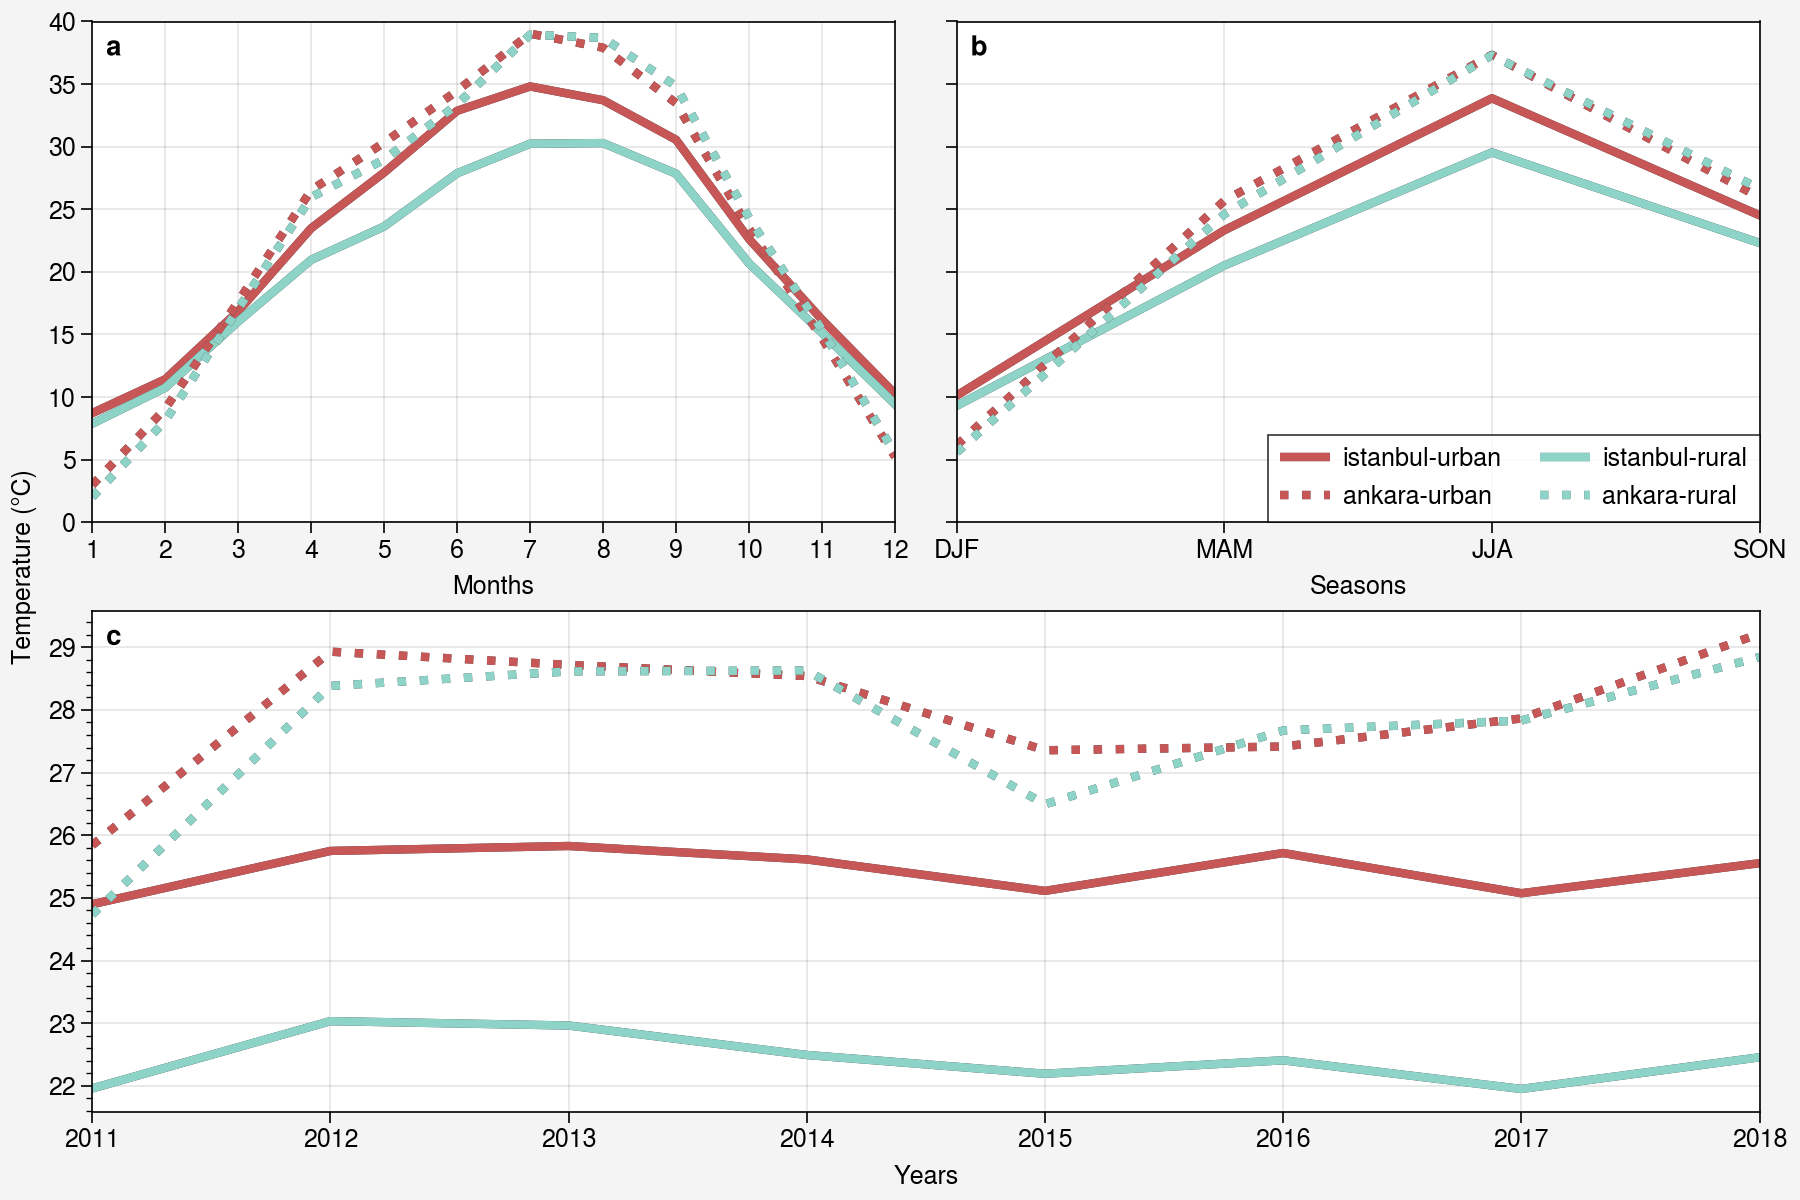

In [10]:
method = 'modis_time_mean_lineplot'

styles = ['-','-',':', ':']
colors = ['#c75757', '#8dd3c7', '#c75757', '#8dd3c7']

modis_time_mean_lineplot(monthly_mean_df,
                           seasonal_mean_df,
                           yearly_mean_df,
                           method,
                           styles,
                           colors)

## 4. Number of Days Analysis

## 5. Data Sparsity

In [15]:
diff = (modis_data_dict['ankara'].groupby('time.season').mean().mean(dim=['x', 'y'])['urban'] - modis_data_dict['ankara'].groupby('time.season').mean()['rural'].mean(dim=['x', 'y']))

In [ ]:
diff.plot()

In [7]:
modis_data_dict['ankara']['urban'].groupby('time.season').mean().mean(dim=['x', 'y']).compute()

<xarray.DataArray 'urban' (season: 4)>
array([ 6.1655817, 37.333115 , 25.688759 , 25.948069 ], dtype=float32)
Coordinates:
    band         int64 1
    spatial_ref  int64 0
  * season       (season) object 'DJF' 'JJA' 'MAM' 'SON'

In [5]:
modis_data_dict['ankara']['rural'].groupby('time.season').mean().mean(dim=['x', 'y']).compute()

<xarray.DataArray 'rural' (season: 4)>
array([ 5.5866976, 37.300865 , 24.609718 , 26.651451 ], dtype=float32)
Coordinates:
    band         int64 1
    spatial_ref  int64 0
  * season       (season) object 'DJF' 'JJA' 'MAM' 'SON'

### 4.1 August

In [20]:
agu_ = modis_data_dict['ankara']['urban'].loc[modis_data_dict['ankara']['time.month'].isin([8])]

In [18]:
# rural not-nan
(~np.isnan(agu_.values)).sum()

5042393

In [19]:
# rural nan
(np.isnan(agu_.values)).sum()

12061423

In [21]:
# urban not-nan
(~np.isnan(agu_.values)).sum()

146915

In [22]:
# urban nan
(np.isnan(agu_.values)).sum()

16956901

### 4.1 June

In [28]:
agu_ = modis_data_dict['ankara']['rural'].loc[modis_data_dict['ankara']['time.month'].isin([6])]

In [29]:
# rural not-nan
(~np.isnan(agu_.values)).sum()

3925004

In [30]:
# rural nan
(np.isnan(agu_.values)).sum()

12627076

In [26]:
# urban not-nan
(~np.isnan(agu_.values)).sum()

118042

In [27]:
# urban nan
(np.isnan(agu_.values)).sum()

16434038

In [32]:
pd_dict = {
    'August':{'urban': 146915,
              'rural': 5042393},
    'June': {'urban': 118042,
              'rural': 3925004},
}

pd_df = pd.DataFrame(pd_dict)

In [ ]:
pd_df['RUrb'] = pd_df[['R3','R4']].pct_change(axis=1)['R4']
pd_df['RRur'] = pd_df[['R6','R5']].pct_change(axis=1)['R5']

In [34]:
pd_df

,August,June
urban,146915,118042
rural,5042393,3925004


In [51]:
pd_df['perc_diff'] = pd_df[['August', 'June']].pct_change(axis=1)['June'] * 100

In [52]:
pd_df

,August,June,perc_diff
urban,146915,118042,-19.652860
rural,5042393,3925004,-22.159895


In [44]:
(146915 - 118042) / 146915 * 100

19.65286049756662

In [45]:
(5042393 - 3925004) / 5042393 * 100

22.15989511329244

In [46]:
146915 * 19.65286049756662 / 100

28873.0

In [47]:
146915 - 28873.0

118042.0